<a href="https://colab.research.google.com/github/TLG442/Research_Project/blob/feature%2Felectricity-consumption-prediction-model%2Fit21222740/CNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
pythonafroz_electricity_smart_meter_data_from_india_path = kagglehub.dataset_download('pythonafroz/electricity-smart-meter-data-from-india')

print('Data source import complete.')


100%|██████████| 176M/176M [00:01<00:00, 124MB/s]

Extracting files...


Data source import complete.


In [3]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming the dataset is stored in the path returned by kagglehub
dataset_path = pythonafroz_electricity_smart_meter_data_from_india_path

# Load the CSV files
df_2020 = pd.read_csv(os.path.join(dataset_path, "CEEW - Smart meter data Bareilly 2020.csv"))
df_2021 = pd.read_csv(os.path.join(dataset_path, "CEEW - Smart meter data Bareilly 2021.csv"))

# Combine data
df = pd.concat([df_2020, df_2021], axis=0, ignore_index=True)

# Select only a fraction of the dataset (e.g., 20%)
fraction = 0.1
df = df.sample(frac=fraction, random_state=42).reset_index(drop=True)

# Convert 'x_Timestamp' to datetime format
df['x_Timestamp'] = pd.to_datetime(df['x_Timestamp'])

# Sort the data by timestamp
df = df.sort_values('x_Timestamp')

# Set timestamp as index (optional, for time series models)
df.set_index('x_Timestamp', inplace=True)

# Drop unnecessary columns for prediction
df = df.drop(columns=['meter', 'y_Freq (Hz)'])  # Keep only relevant features

# Check for missing values
print(df.isnull().sum())

# Fill missing values if any (you can also try other imputation methods)
df = df.fillna(method='ffill')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Create sequences for the GRU model
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        xs.append(data[i:i+sequence_length])
        ys.append(data[i+sequence_length, 0])  # Target is 't_kWh' (first column after scaling)
    return np.array(xs), np.array(ys)

# Sequence length for time steps (e.g., 60 minutes/steps)
sequence_length = 60

# Split the scaled data into training and test datasets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape the data for GRU input (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Print the shape of the data
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


t_kWh                   0
z_Avg Voltage (Volt)    0
z_Avg Current (Amp)     0
dtype: int64


<ipython-input-3-37c3774c1f9b>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


X_train shape: (846045, 60, 3), y_train shape: (846045,)
X_test shape: (211467, 60, 3), y_test shape: (211467,)


In [10]:
from keras.models import Sequential
from keras.layers import GRU, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build a combined model with GRU, LSTM, and CNN
model = Sequential()

# 1D Convolutional Layer to extract local features
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Add an LSTM layer to capture long-term dependencies
model.add(LSTM(units=100, return_sequences=True))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Add a GRU layer to capture short-term dependencies
model.add(GRU(units=100, return_sequences=False))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Fully connected layer to combine features learned from previous layers
model.add(Dense(units=100))
model.add(Activation('relu'))

# Dropout layer to prevent overfitting
model.add(Dropout(0.3))

# Output layer for regression (predicting 't_kWh')
model.add(Dense(units=1))

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', 'mse'])

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
13220/13220 ━━━━━━━━━━━━━━━━━━━━ 168s 12ms/step - loss: 0.0122 - mae: 0.0578 - mse: 0.0122 - val_loss: 0.0100 - val_mae: 0.0642 - val_mse: 0.0100 - learning_rate: 0.0010
Epoch 2/5
13220/13220 ━━━━━━━━━━━━━━━━━━━━ 199s 12ms/step - loss: 0.0059 - mae: 0.0471 - mse: 0.0059 - val_loss: 0.0100 - val_mae: 0.0639 - val_mse: 0.0100 - learning_rate: 0.0010
Epoch 3/5
13220/13220 ━━━━━━━━━━━━━━━━━━━━ 212s 13ms/step - loss: 0.0059 - mae: 0.0469 - mse: 0.0059 - val_loss: 0.0100 - val_mae: 0.0623 - val_mse: 0.0100 - learning_rate: 0.0010
Epoch 4/5
13220/13220 ━━━━━━━━━━━━━━━━━━━━ 202s 13ms/step - loss: 0.0059 - mae: 0.0468 - mse: 0.0059 - val_loss: 0.0100 - val_mae: 0.0631 - val_mse: 0.0100 - learning_rate: 0.0010
Epoch 5/5
13220/13220 ━━━━━━━━━━━━━━━━━━━━ 210s 14ms/step - loss: 0.0059 - mae: 0.0467 - mse: 0.0059 - val_loss: 0.0100 - val_mae: 0.0634 - val_mse: 0.0100 - learning_rate: 0.0010


In [11]:
# Evaluate the model on the test data
test_loss, test_mae, test_mse = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")
print(f"Test MSE: {test_mse}")


6609/6609 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.0092 - mae: 0.0604 - mse: 0.0092
Test Loss: 0.009979158639907837
Test MAE: 0.06343251466751099
Test MSE: 0.009979158639907837


6609/6609 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


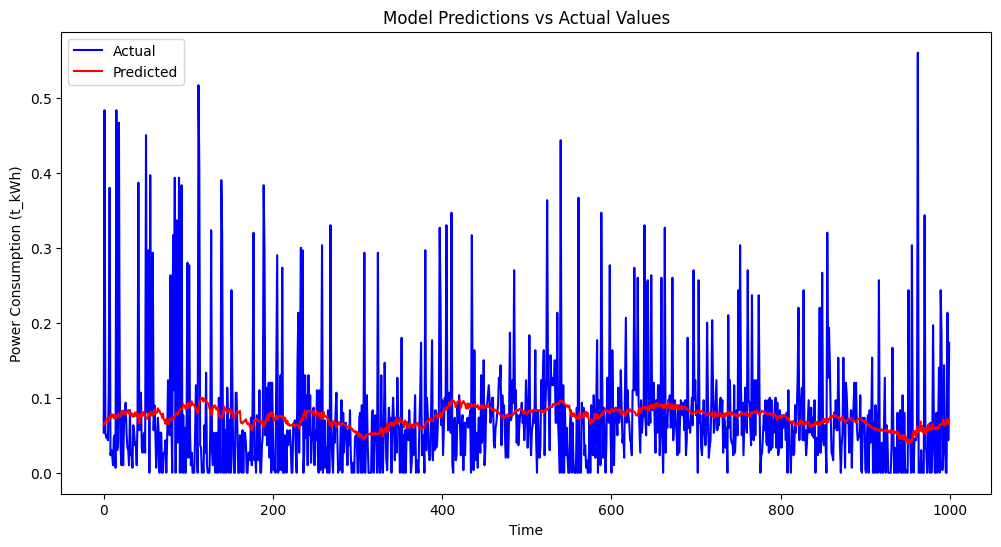

In [12]:
# Predict on the test set
y_pred = model.predict(X_test)


# Visualize the predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test[:1000], label='Actual', color='blue')  # Plot first 100 actual values
plt.plot(y_pred[:1000], label='Predicted', color='red')  # Plot first 100 predicted values
plt.legend()
plt.title('Model Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Power Consumption (t_kWh)')
plt.show()


In [13]:

# Metrics calculation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(r2)


0.03918477792636843


In [15]:
# Save the GRU model to a file
model.save('smart_meter_conv_lstm_gru_model.h5')
